In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from nose.tools import *

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import tree

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score 
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV,ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR,SVR

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, make_scorer

# Modeling of the electricity generation photovoltaic power plant using machine learning methods

Only the file path for the excell files with recorded data must be specified, in order to run the notebook.

## Experiment about the lenght of the training period, and its effect on the prediction errors 

### Author: Tanyo Tanev

#### ABSTRACT
.

Photovoltaic power plants are one of the biggest hopes for increased share of the renewable sources in the power generation. The electricity needs of every person in Bulgaria, Europe and especially in Africa, China and India will rise. Every possibility for energy efficiency must be exploited, but the absolute value of used energy per capita per year will rise. In order to have as clear, healthy, and stable environment as possible in the process of making the life of everyone better in the next decades, we must look for every possibility for clear and renewable energy production.
The renewable energy sources, however, have their technical downsides, as well. There is technical limitation of how much of the rapidly changing solar energy a national power grid can sustain and include in the mix, without falling appart, due to the unstability. A falling appart, or a black out, of national grid is very costly, endangers human lifes, especially in the manufacturing and has economical effects that last with decades. In other words, should be avoided. 
One way of increasing the possible limit of the number of PV PP that could connect safely to the grid is to increase their forecasting accuracy. When the operator of the grid is well aware what energy to expect from the changing PV PP, the amount of the needed reserving power will be reduced.
This paper researched several techniques in order to check practicality of machine learning methods for generation prediction of a real life PP, situated in North Bulgaria, for the period of September 2012 till March 2013.

## 1.Introduction

In the recent years, as the technologies of photovoltaic modules improved in a considerable margin, and the various incentives introduced in many countries, especially in the European Union, the photovoltaic power plants rapidly increased. Their purposes and scale vary from several kWp installed power up to tens of MWp. Their general purposes are from small power stations from mobile operators equipment, installed in remote areas, house roof usage and small generation, to small and factories self needs (from 100 kWp up to 40 MWp), and electricity generation and sells from 100 kWp up to 50 MWp. The accurate photovoltaic production forecasting is necessary for the optimal integration of the technology into the existing power systems and is important for both grid and plant operators (owners). The changing nature of the pv power plant generation complicates the power systems stability, or even poses a threath for it. The power grid and system can sustain some share of PV plants, connected to it, but to a certain extenct. In order to keep the systems stability and voltage level, the system operators must always have some reserve power (secondary reserve), short and midterm, which could replace the solar pp, which unexpectedly reduced its production due to the weather conditions. More specifically, short-term PV production forecasts (intrahour) is necessary for power ramp and voltage flicker prediction as well as control operations and dispatch management. On the other hand, mid-term PV production forecasting (intra-day and day-ahead) is used for load consumption and production monitoring to control voltage and frequency levels and reduce secondary reserve.

PV production forecasts have only recently been introduced into the electricity system operational practices. Most commonly adopted approaches are based on parametric models that require detailed PV system parameters and characteristics. This information is not always available, or even accurate, even from the producer. These parameter models, could need for many parameters, or specifics of the given PP to be accurate. Additionally, with time, the pv module materials reduce their efficiency with the years, which parameter could be assumed, but cannot be calculated.

In this sense, parametric models are driven by the performance of the component models and parameters. In the scope of improving the forecasting accuracy of the generated power, adaptive machine learning approaches that can capture system behaviour without the need of datasheet and installation parameters have been gaining ground. Due to this, there are various experiments with different types equipment (modules and inverters), locations and machine learning alghoritms tested.

#### Functions 

In [2]:
def plot_power_graph(Y,Y_predicted, string = str):
    """
    Function,  which plots the test values for Y, and Y_predicted values. The string parameter represents the label 
    of the predicted values on the plot.
    """
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 12}) # must set in top

    plt.plot(Y.index, Y_predicted, label = string)
    plt.plot(Y.index, Y, label = "Real generation")
    plt.legend(loc="upper left")
    plt.xlabel("Measurements, 5 min")
    plt.ylabel("Generated power, W")
    plt.show()

In [3]:
def RMSE_calc(Y,Y_predict, Y_test,Y_predict_test):
    """
    Function,  which calculates and plots the root mean squared error for Y measured and Y predicted values for both the 
    whole period (test + train) and test period.
    """
    print(f"Rooted MSE whole period : {np.sqrt(mean_squared_error(Y, Y_predict))/1000:.2f} kW")
    print(f"Rooted MSE test period : {np.sqrt(mean_squared_error(Y_test, Y_predict_test))/1000:.2f} kW")
    print(f"Normalised Rooted MSE test period : {np.sqrt(mean_squared_error(Y_test, Y_predict_test))/1000*100/8/12:.2f} %")

In [4]:
def RMSE_calc_during_days(Y, Y_predict, Y_test, Y_predict_test):
    """
    Function,  which calculates and plots the root mean squared error for Y measured and Y predicted values for both the 
    whole period (test + train) and test period. 
    The specific is that, this function calculated the r mse , EXCLUDING the periods during the night, when both 
    Y and Y_predict are zero.
    """   
    
    #print(f"Rooted MSE whole period : {np.sqrt(mean_squared_error(Y, X_predict))/1000:.2f} kW")
    MSE = list()
    MSE_all = list()
    counter = 0
    counter_all = 0
    i=0
    for idx in range(Y_test.index.min(),Y_test.index.max()):
        if Y_test[idx] > 0: 
            counter +=1
            MSE.append((Y_test[idx] - Y_predict_test[i])**2)
        i+=1
  
    for idx in range(Y.index.min(),Y.index.max()):
        if Y[idx] > 0: 
            counter_all +=1
            MSE_all.append((Y[idx] - Y_predict[idx])**2)

    print(f"Rooted MSE whole period (only daylight): {np.sqrt(sum(MSE_all)/counter_all)/1000:.2f} kW")
    print(f"Rooted MSE test period (only daylight): {np.sqrt(sum(MSE)/counter)/1000:.2f} kW")
    print(f"Normalized Rooted MSE test period (only daylight): {np.sqrt(sum(MSE)/counter)/1000*100/8/12:.2f} %")
    
    #print(Y_test.index.max())
    #print(Y_test.index.min())
    #print(Y.index.max())
    #print(Y.index.min())
    #print(X_predict_test[i])
    #print(X_predict_test.index.min())
    #print(counter)
    #print(counter_all)
    #print(sum(MSE))
    #print(sum(MSE_all))
    #print(i)

In [5]:
def train_validate_test_split(df, train_percent=0.6, validate_percent=0.2):

    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

In [6]:
def plot_days(Y, Y_predicted, label_regression_type,  beggining, end = None):

    if end is None:
        end = len(Y)
    plt_period_begginig = end - beggining*288
    
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 12}) # must set in top
    
    plt.title(f"Power generation comparison between measured and predicted values from {label_regression_type}")
    plt.plot(Y[plt_period_begginig:end].index, Y_predicted[plt_period_begginig:end], label = f"Predicted generation {label_regression_type}")
    plt.plot(Y[plt_period_begginig:end].index, Y[plt_period_begginig:end], label = "Real generation")
    plt.legend(loc="upper left")
    plt.xlabel("Measurements, 5 min")
    plt.ylabel("Generated power, W")
    plt.show()

In [7]:
def plot_residuals(Y,Y_predicted, label):
    plt.figure(figsize=(20,13))
    plt.rcParams.update({'font.size': 12}) # must set in top

    plt.scatter(Y, Y - Y_predicted, label = label, s=5)
    plt.xlim(Y.min(), Y_predicted.max()*1.05)
    plt.legend(loc="upper left")
    plt.xlabel("Measured, kW")
    plt.ylabel("Measured - Estimated, W")
    plt.show()

## 2.Previous work

In [1] are presented are presented three ML methods - Artificial Neural Networks (ANNs), Support Vector Regression (SVR)
and Regression Trees (RT), and their prediction performance on the generated power of a grid-connected PV system of five poly-c
Si PV modules, rated at 235 Wp each, and in total 1175 Wp installed power. The used metrics were MAE, MAPE, RMSE and nRMSE. 
MAPE in the case of PV power forecast is affected by a big differences in the small values of Y and Y predicted, which could give more weight on the small values and could twist the information of the mectric. The reached nRMSE are 0.76, 1.13 and 1.33 for ANN, SVR and RT respectively. Specifically, the meteorological measurements include the incident global irradiance (GI), relative humidity (RH), wind direction (Wa), wind speed (Ws), as well as ambient temperature (Tamb). The PV system operational measurements include maximum power current (Imp), voltage (Vmp) and power (Pmp), as measured at the output of the PV system (dc side). For a scientific purposes, it is helpful to measure and include in the model as many parameters as possible. For practicle purposes though, it is not always possible to measure RH, or wind direction, and even harded to predict them, in order to predict the dependent variable - generated power. Also, the effect of the clouds and their shape (as the later is not possible to predict), covering practically big PP with area of several pr even tens of decares is something that any proposed model should be tested.
A research, implemented with real life power plant, with independent parameters, that could be forecasted and in this way used for practical power generation forecasts.

In [2] was presented modeling of the generation of 5 PV PP, situated on different geographic locations, from 20 to 150 kW. The performances of several method was checked - Time series, Lasso Regressiom, K-Nearest Neighboors, Gradient Boosting Regression Trees and ANN, with metrics RMSE, and nRMSE. One issue with the data that they use is there is no recorded data on the sites themselves, which possible introduce an error. However, if the models are used later for real forecasting, based on the meteorologicals stations forecasts, the models already will be trained on the data from the same meteo sites(as geographical places). They used 22 climatic parametes, including diffuse, global and direct radiance, effectiva cloud cover, high medium cloud cover. A 6 months 6 k-folds were used for model training. The study concluded that GBRT and ANN perfermed better, and that the global radiation feature has a high importance, as obviously encircle many other climatic conditions in one variable. Other conslusions for improving the results is the assumption that the model trained choses optimal coefficients for the whole year(or k-fold period), but if the year is splitted into a winter and summer season, and then train the models independently should be expected to improve results. Or train models for the peak iradiance and power generation part of the day and morning/low light part of the day. 
If this is implemented, it will bring not small practical difficulties. Additionally, the photovoltaic materials deteriorate with the years.This is a slow process, expectedly 40 % for 25 years, but still makes it more rewarding to retrain over some period.  

Such proposals point out that a research whether a retraining of pretrained model, using a more recent data will be beneficial. 

## 3. Data sources

The used data is from a real life PV PP near Medkovetz, Bulgaria with installed power of 103 kWp, 448 pcs of pv modules per 230 Wp, connected to the grid through 8 inverters per 12 kW. The inverters, have two DC inputs - A and B. The power plant area is around 2 decares, and a solar iradiance and  ambient temperature meters installed and connected to the inverters. The inverters record the data in excel file for each day. The recordings are made on every 5 minutes, 288 per day. The recorded parameters are total produced power of the plant - the outer AC electrical energy from all 8 inverters, the produced and summed PV DC energy of A input and B input. Also, the ambient tempeture, the wind speed, the global solar radiance (insolation). The total measurements are 51 264. The first recorded date is 2012-9-5 and the final is 2013-3-30, with total days 178. 
Twenty eight day are not included in the research as many values are missing due to some technical fault. For example 2012-10-21 had a problem with the inverter, which did not send power data for the day.

## 4.Initial Data Exploration

In [8]:
#files = os.listdir("C:\Полигона\Докторантура\Paper module\PV_Medkovets_Sunflex\PV_Medkovets_Sunflex")
#files 

In [9]:
#files_csv = [f for f in files if f[-3:] == 'csv']
#files_csv

In [10]:
df = pd.DataFrame()

In [11]:
path = r'C:\Полигона\Програмиране\Artificial intelligence\Machine Learning\PROJECT\PROJECT' # use the path
files_csv = glob.glob(path + "/*.csv")
#files_csv

In [12]:
counter = 0
col_list = ["Power","DC power input[B]", "DC power input[A]", "Wind speed", "Ambient temperature", "Insolation", "Module temperature"]

for f in files_csv:
    data = pd.read_csv(f,sep=";", header = 5, skiprows=[6,7], usecols=col_list)
    df = df.append(data)
    counter+=1

In [13]:
#counter
#df.head()

In [14]:
df = df.reset_index()

In [15]:
df = df.drop('index', axis = 1)

In [16]:
df.tail()
#df.shape

,Power,Wind speed,Module temperature,Ambient temperature,Insolation,DC power input[A],DC power input[B]
51259,0,0.58,2.6,4.5,0.0,NaN,0
51260,0,0.28,2.5,4.4,0.0,NaN,0
51261,0,0.26,2.5,4.4,0.0,NaN,0
51262,0,0.17,2.5,4.4,0.0,NaN,0
51263,0,0.26,2.4,4.4,0.0,NaN,0


In [17]:
df.corr()

,Power,Wind speed,Module temperature,Ambient temperature,Insolation,DC power input[A],DC power input[B]
Power,1.000000,0.318393,0.746859,0.469296,0.989987,0.998370,0.998520
Wind speed,0.318393,1.000000,0.232290,0.190100,0.315748,0.293389,0.317434
Module temperature,0.746859,0.232290,1.000000,0.921292,0.767011,0.759406,0.749971
Ambient temperature,0.469296,0.190100,0.921292,1.000000,0.493793,0.489975,0.472974
Insolation,0.989987,0.315748,0.767011,0.493793,1.000000,0.986073,0.988928
DC power input[A],0.998370,0.293389,0.759406,0.489975,0.986073,1.000000,0.998801
DC power input[B],0.998520,0.317434,0.749971,0.472974,0.988928,0.998801,1.000000


In [18]:
print(len(df[np.isnan(df['Power'])]))
print(len(df[np.isnan(df['Wind speed'])]))
print(len(df[np.isnan(df['Ambient temperature'])]))
print(len(df[np.isnan(df['Module temperature'])]))
print(len(df[np.isnan(df['Insolation'])]))
#pd.isnull(df).any(df['Power']).nonzero()[0]
df[np.isnan(df['Insolation'])].head()

0
26
2
2
23


,Power,Wind speed,Module temperature,Ambient temperature,Insolation,DC power input[A],DC power input[B]
7824,0,NaN,14.0,16.7,NaN,NaN,0
7827,0,NaN,14.1,17.2,NaN,NaN,0
7828,0,NaN,14.1,17.2,NaN,NaN,0
7829,0,NaN,14.1,17.2,NaN,NaN,0
7830,0,NaN,14.1,17.2,NaN,NaN,0


In [19]:
df = df.fillna(0)

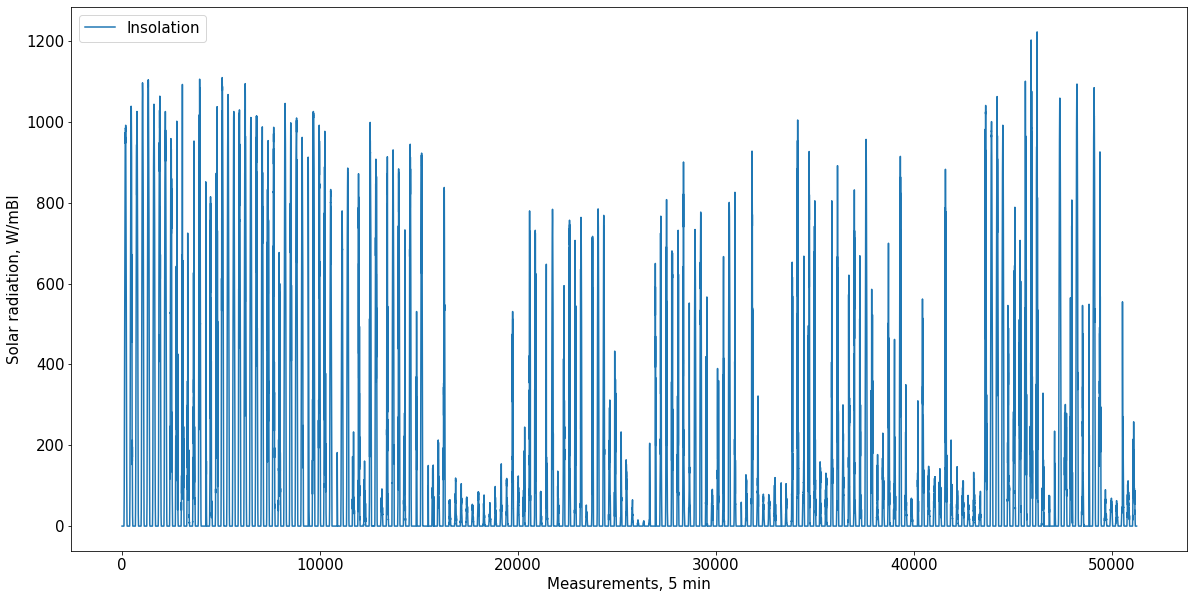

In [20]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15}) # must set in top

plt.plot(df["Insolation"].index, df["Insolation"], label = "Insolation")
plt.legend(loc="upper left")
plt.xlabel("Measurements, 5 min")
plt.ylabel("Solar radiation, W/mВІ")
plt.show()

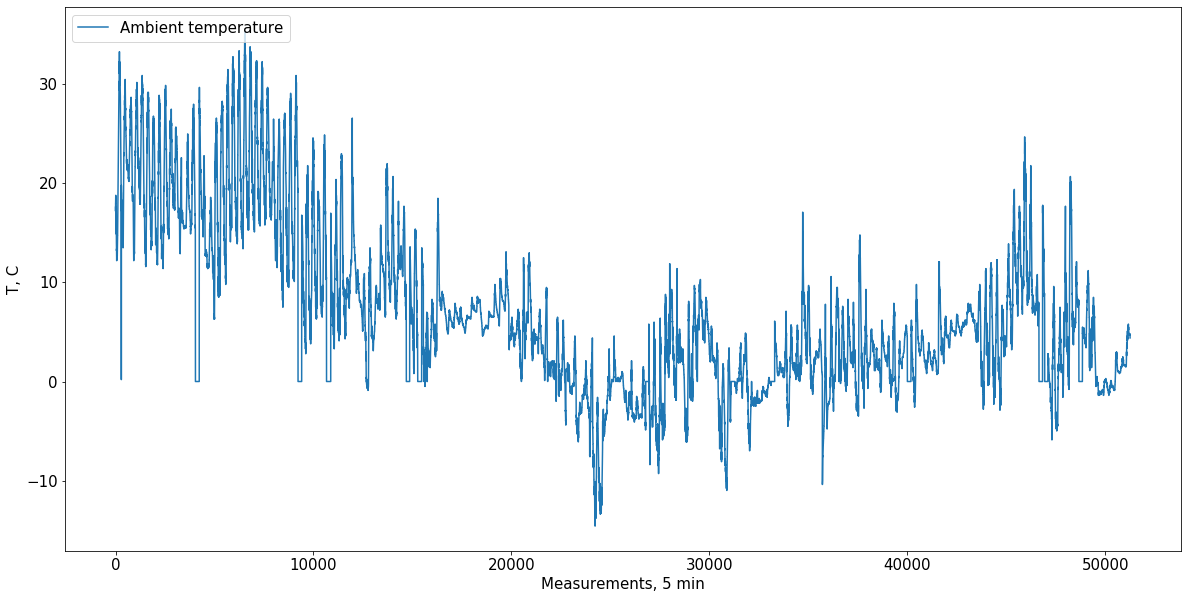

In [21]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15}) # must set in top

plt.plot(df["Ambient temperature"].index, df["Ambient temperature"], label = "Ambient temperature")
plt.legend(loc="upper left")
plt.xlabel("Measurements, 5 min")
plt.ylabel("T, C")
plt.show()

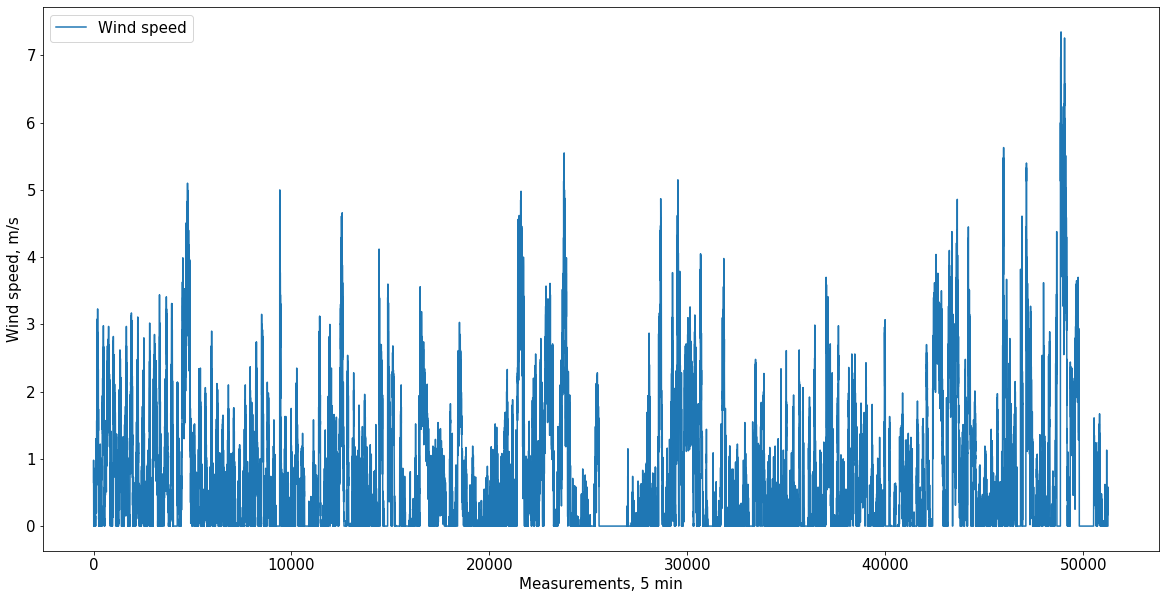

In [22]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15}) # must set in top

plt.plot(df["Wind speed"].index, df["Wind speed"], label = "Wind speed")
plt.legend(loc="upper left")
plt.xlabel("Measurements, 5 min")
plt.ylabel("Wind speed, m/s")
plt.show()

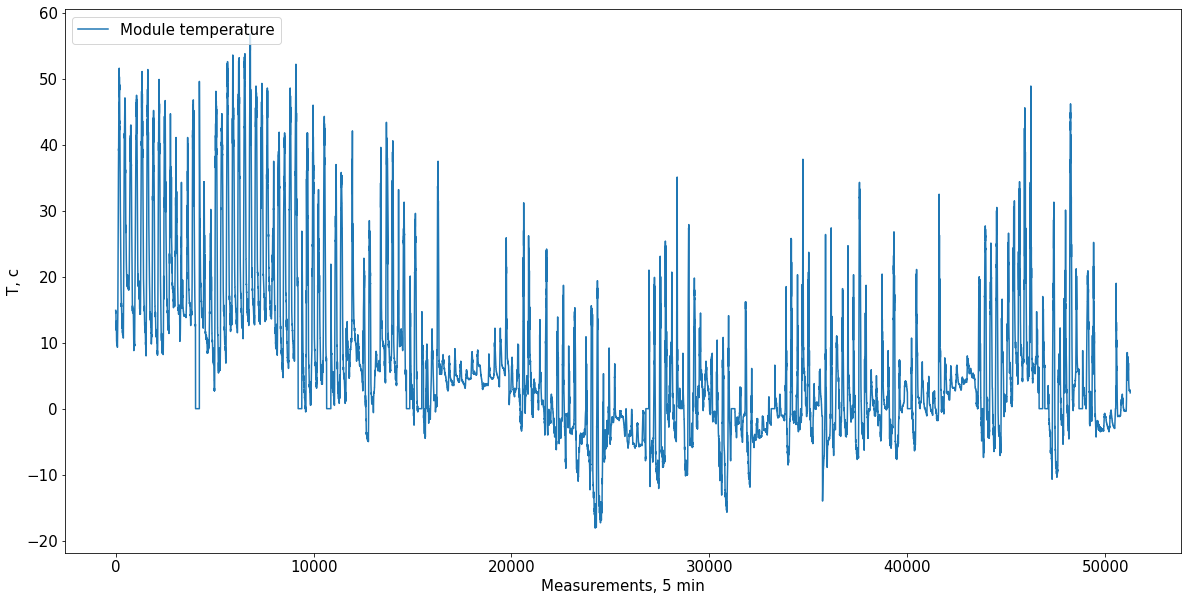

In [23]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15}) 

plt.plot(df["Module temperature"].index, df["Module temperature"], label = "Module temperature")
plt.legend(loc="upper left")
plt.xlabel("Measurements, 5 min")
plt.ylabel("T, c")
plt.show()

From what we can see from the data exploration, the wind is randomly distrituted through the data. The solar radiation is as expected, more and higher on autumn, and March, and lower in winter. The same is with the module and ambient temperature.

There is possibility that the seasonality of the data will affect the results of a model. If this happens, a season models could be considered, or cycly retraining of the optimal estimator.

Here, we could notice that some portion (5.93%) of the measuremets for the dependent variable Power are in fact NaN values. The main reason for that is that when there is no solar iradiance (insolation), some of the meters work and record, and the parameters of generated power - Power, are NaN. Or in cases when there is some fault and the whole PP is not working and generating, and there are less than 288 measurements for the day on every 5 minutes, (and recorded data starts not in 0:00, but in 11:25) for the periods intergrity, we add the whole day, with NaNs from the 0:00 moment of the day. Due to this reasons, it is safe to fill all NaN values with zeros. We can hope that there are no other types of cases when some parameter is NaN. If there are such, we can research it on the graphs of predicted values or scatter plots of residuals.

## 5.Regression analysis

In [24]:
PV_features_unshaped = df[['Ambient temperature', 'Insolation','Wind speed', "Module temperature"]] #
PV_features_unshaped.shape

(51264, 4)

In [25]:
PV_y_unshaped = df.Power
PV_y_unshaped.shape

(51264,)

In this section the available data will be divided in two parts - (train + validation) set and final test set in 90/10 proportion. The (train + validation) part of the data will be again divided via train_test_split method again in 80 to 10 proportion, so that the whole data is split in roughly 80/10/10 percent parts. The reason why it is chosen to be implemented in this way, and not in the presented specific function train_validate_test_split is, that later, when Polynomian transformation is introduced, the PolynomialFeatures() returns numpy.ndarray which does have index.

In [26]:
print(len(PV_y_unshaped))
end_of_validation_set = round(len(PV_y_unshaped) * 0.9)
print(end_of_validation_set)

PV_y_test = PV_y_unshaped[end_of_validation_set:]
print(f"final test shape{PV_y_test.shape}")

PV_features_test = PV_features_unshaped[end_of_validation_set:]
print(f"final features test shape{PV_features_test.shape}")

PV_features = PV_features_unshaped[:end_of_validation_set] #(PV_train + PV_validation)
print(PV_features.shape)
PV_y = PV_y_unshaped[:end_of_validation_set]
print(PV_y.shape)

51264
46138
final test shape(5126,)
final features test shape(5126, 4)
(46138, 4)
(46138,)


In [27]:
#PV_features_train, PV_features_validate, PV_features_test = train_validate_test_split(PV_features, train_percent=0.7, validate_percent=0.2 )

In [28]:
#PV_y_train, PV_y_validate, PV_y_test = train_validate_test_split(PV_y, train_percent=0.7, validate_percent=0.2 )

In [29]:
#PV_y_train.shape, PV_features_train.shape

In [30]:
PV_y.shape, PV_features.shape

((46138,), (46138, 4))

#### Baseline model 

First, the following shows the baseline score with the basic Linear Regression. 

In [31]:
PV_features_train, PV_features_validate, PV_y_train, PV_y_validate = train_test_split(PV_features, PV_y, test_size=0.10, shuffle = False)

model = LinearRegression()
model.fit(PV_features_train, PV_y_train)
baseline_score = model.score(PV_features_validate, PV_y_validate)
round(baseline_score,5)

0.98479

From this baseline score could be assumed that the available data and the proposed features even the base estimator gives quite 
good prediction results. There seems to be little to gain or improve from this point. Of course, it will be helpful to plot the 
predicted and measured data, in order to check the real situation.

As noted and tried in [6] a Time Series Models show dissapointing results, as they cannot model in any way the clouds, and their shape. In other words, the solar irradiance meter could show midday high radiance, and the big enough part of the PV PP to be shadowed by clouds, generating unexpectedly lower power given the measured radiance. 

The research done in NASA published in 1965 [7] give a good insight on the issue - "The power loss associated with shadowing one or more complete series of cells (inside the PV module) is significantly greater than would be computed on a percent shadow basis because of the shunting action (due to the diode characteristic) of the shadowed cells." 
They noticed that when 25% of the cells of one 1 of 8 series of cells are shadowed, the total loss of power is 1/8. When the shadowing is on 4 series of 8, even when less than 10% of the cells in these series are shadowed, the total loss of produced power is 50%. 
The other reason, of course is that there is no energy accumulation in the photovoltaic effect. It occurs only when a photon is absorbed by the pv material (often silicon) and if the photon energy is higher than the silicon band gap value. When there is no light, the effect immediately stops  [8].

We can try this with the baseline model, but using shuffle this time. The result is very close, even seem to be a little higher - 0.978-0.986, as there is a period in the validation part the data, that is more difficult for the model to predict. The proposed research goal is to continue studying the forecasting of power generation of PV PP to be without shuffling, for several reasons:

- keeping the continuity and the order of the days, we could notice if some issue from the real life operation of the given plant is happening. If there are some long periods where the model is not predicting we could try to investigate why this is happening, and to propose a solution.

#### shuffling baseline model

In [32]:
PV_features_train_new, PV_features_validate_new, PV_y_train_new, PV_y_validate_new = train_test_split(PV_features, PV_y, test_size=0.10, shuffle = True)

model_shuffle = LinearRegression()
model_shuffle.fit(PV_features_train_new, PV_y_train_new)
baseline_score = model_shuffle.score(PV_features_validate_new, PV_y_validate_new)
round(baseline_score,5)

0.97997

##### end of shuffling baseline model

In [33]:
PV_predicted_all = model.predict(PV_features) # predicted for the train + validate period

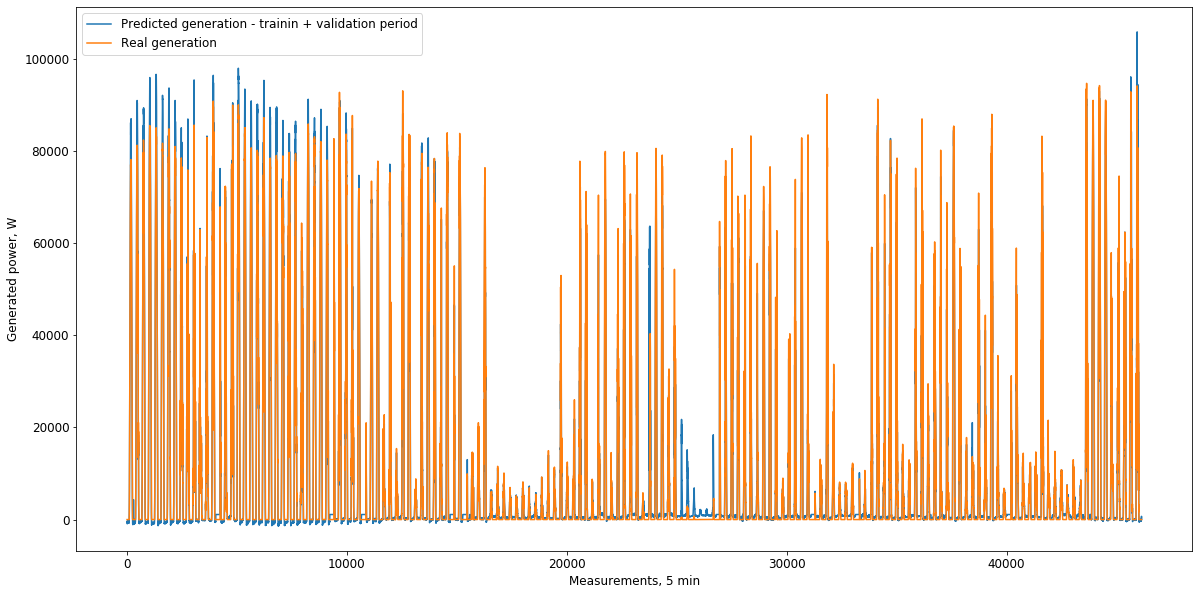

In [34]:
plot_power_graph(PV_y,PV_predicted_all, "Predicted generation - trainin + validation period")

In [35]:
print(PV_predicted_all.min())
print(PV_y.min())

-1417.249562927862
0


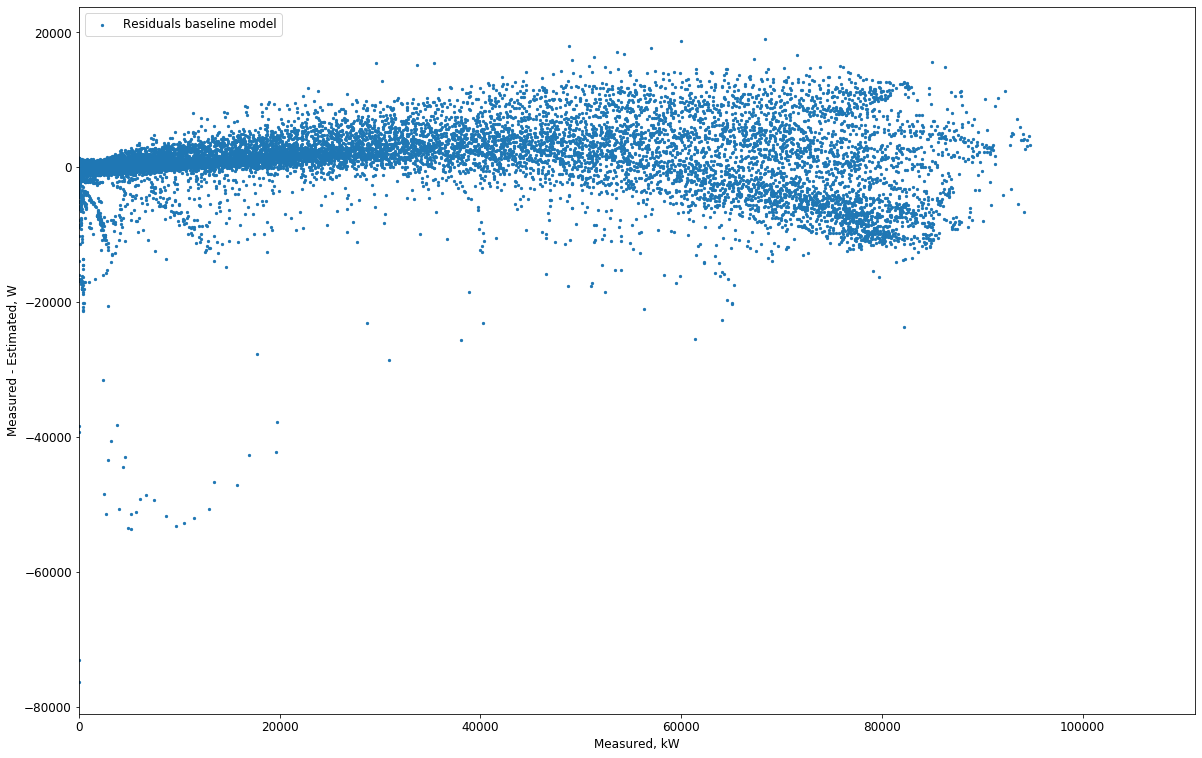

In [36]:
plot_residuals(PV_y,PV_predicted_all, "Residuals baseline model")

From the graph could be noticed that the predicted value in some cases drops below zero, and compared to the measured value of the Power - PV_y - which does not have negative values, is something which we must address - and hopefully to find reasons and solution.
Another issue from the graph is that in the latter days of the available data (each day looking like a one line) is that the predicted values are much higher than the recorded values. The same could be noticed also for the beggining period. This could be due to the fact that the regression model is calculating optimal coefficients for the independent variables across the whole period. The produced electrical energy is higher in the summer and lower in the winter. 
If this seasonality affects somehow the coefficients of the model parameters, it looks like the predicted power should be close to the average year times, lower than measured in the highes periods of the summer and higher than the lower periods of winter (although we cannot be 100 % sure about that). We see something in the opposite, though. The first period starts from September 2012, and the later period is around end of March 2013. 

It is possible, as well, that there is some non-linear connection between independent variables and the dependent, which a polynomial features will help explain better. 

Another possible reason is that 1 of the 8 inverters of the PP is faulted for some time, which we could not know at the moment. In this case the predicted will be higher than measured in a consistent period of days (if it repair took more than one day).

Additional possibility is that the solar irradiance meter is measuring the full solar irradiance at the moment, but the area of 200 kWp installed power PP is around 2000 sq meters. If some cloud/s "cover" for some time parts of the PP, and not the solar irradiance meter, the model will generate higher predicted in this periods. Such periods could be short, could be longer, but not always and every day. On the other hand, such periods happen for sure, and introduce the internal error of the data, a kind of noise, that cannot be predicted (because we cannot know the shape of the clouds).


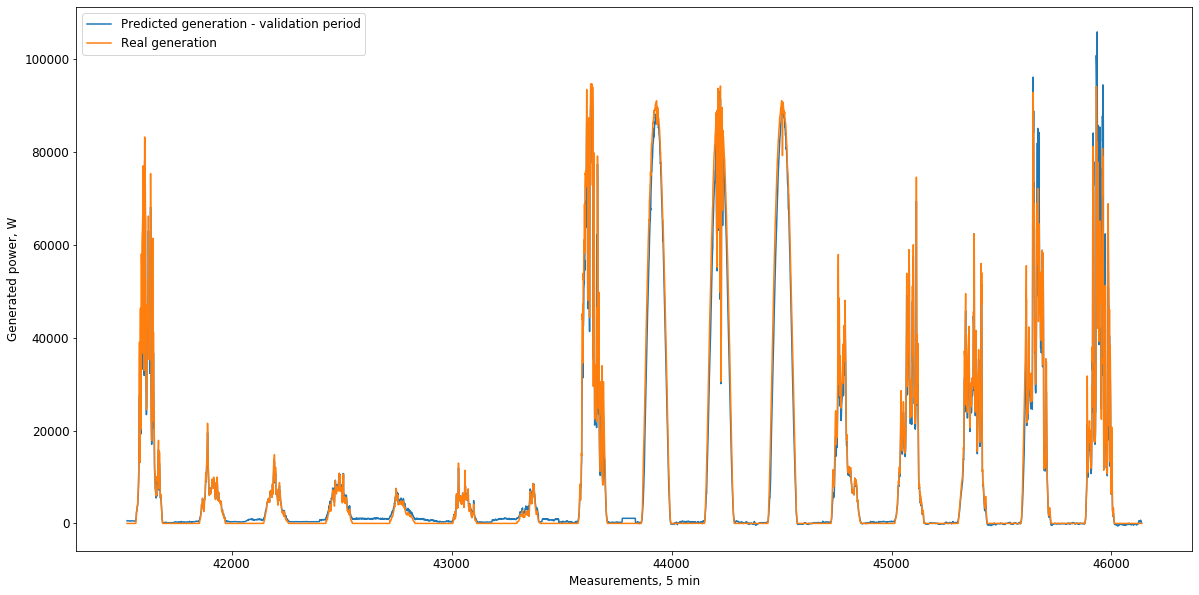

In [37]:
PV_predicted_validate = model.predict(PV_features_validate) # predicted for the validation period
plot_power_graph(PV_y_validate,PV_predicted_validate, "Predicted generation - validation period")

In [38]:
#PV_features_validate.max(), PV_predicted_all.max()

From the graphs for the training and validation periods could be noticed that there is serious difference between the peak values of the measured power and the predicted power. We must see other metrics as well, and plot only several days to check not only the peak, but the slope as well.

In [39]:
RMSE_calc(PV_y , PV_predicted_all, PV_y_validate, PV_predicted_validate)

Rooted MSE whole period : 2.91 kW
Rooted MSE test period : 2.70 kW
Normalised Rooted MSE test period : 2.81 %


The chosen metric is Rooted Mean Square Error, which will give us the average difference between. Additional metric is the normalized RMSE. The normalization is based on the installed power of the power plant of 103 kWp.

In [40]:
print(f"Rooted MAE train+validate period : {(mean_absolute_error(PV_y , PV_predicted_all))/1000:.2f} kW")
print(f"Rooted MAE test period : {(mean_absolute_error(PV_y_validate, PV_predicted_validate))/1000:.2f} kW")

Rooted MAE train+validate period : 1.36 kW
Rooted MAE test period : 1.32 kW


Here a Mean Absolute Error is presented for the baseline model and it is much lower than RMSE. As MAE is showing the average results, and RMSE gives a relatively high weight to large errors. The errors of the predicted values, where the power plant is just starting to generate in the morning, or reducing the generated power in the evening, are small errors. These small errors are not informative for us, will give us wrong improvession of very low error. We prefer to give more emphasison the higher margin errors, which occur during midday, which could hamper the connection quality with electrical grid, and make the cooperation with the energy distribution operation more difficult. For this reason, we will use RMSE and n RMSE, and not MAE [5].


### 5.1 Normamization and PCA 

In [41]:
sc = MinMaxScaler()
scaled_X = sc.fit_transform(PV_features)
scaled_X.shape
print(len(scaled_X), len(PV_y))

#PV_features_train, PV_features_validate, PV_y_train, PV_y_validate = train_test_split(scaled_X, PV_y, test_size=0.10, shuffle = False)

46138 46138


In [42]:
pca = PCA()
X_pca = pca.fit_transform(scaled_X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)
X_pca = X_pca[:,:3]
X_pca.shape

PV_features = X_pca

(46138, 4)
[0.66133827 0.19885833 0.13709331 0.0027101 ]


### 5.2 Polynomial features and degree

The simple linear baseline model showed good results for the validation test. One of the next things which we must check is whether there are non-linear dependencies between the proposed independent variables and the dependent variable for this research. With the next step we will perform something like manual gridsearchcv with polynomial engineered features, in order to cheack and expose eventual non-linear depencency. The cv folds are chosen 5. The alghoritm will present the best performed feature degree from 1 to 6, and if interactions between variables improve R2 or not [4].

In [43]:
X_train, X_test, PV_y_train, PV_y_test = train_test_split(PV_features, PV_y, test_size=0.20, shuffle = False)

degrees = [1, 2, 3, 4, 5, 6] # Change degree "hyperparameter" here
#normalizes = [True, False] # Change normalize hyperparameter here
interactions = [True, False] # Change normalize hyperparameter here
best_average_score = 0
best_degree = 0
scores_list = list()
for degree in degrees:
   # for normalize in normalizes:
     for interaction in interactions:
        poly_features = PolynomialFeatures(degree = degree, interaction_only = interaction)
        X_train_poly = poly_features.fit_transform(X_train)
        polynomial_regressor = LinearRegression()
        polynomial_regressor.fit(X_train_poly, PV_y_train)
        scores = cross_val_score(polynomial_regressor, X_train_poly, PV_y_train, cv=5) # Change k-fold cv value here
        print(scores)
        scores_list.append(round(sum(scores) / len(scores),5))
        
        if sum(scores) / len(scores) > best_average_score: # mean of the list of the scores for the cross validation
            best_average_score = sum(scores) / len(scores)
            best_degree = degree
            best_list_scores = scores
            best_interaction = interaction

[0.97334197 0.98941782 0.97826903 0.92777949 0.97274153]
[0.97334197 0.98941782 0.97826903 0.92777949 0.97274153]
[0.97770443 0.99142665 0.98209891 0.92410633 0.97852052]
[0.99311235 0.9937688  0.98983294 0.92844857 0.98737262]
[0.97818039 0.99137798 0.9826696  0.92463597 0.97789781]
[0.99112791 0.9923436  0.99055351 0.9303499  0.98319746]
[0.97818039 0.99137798 0.9826696  0.92463597 0.97789781]
[0.99299895 0.99390733 0.99174388 0.93238732 0.96491946]
[0.97818039 0.99137798 0.9826696  0.92463597 0.97789781]
[0.97320558 0.99406622 0.99221763 0.92712531 0.93228222]
[0.97818039 0.99137798 0.9826696  0.92463597 0.97789781]
[0.98072617 0.9942104  0.99330871 0.90893645 0.91959464]


In [44]:
print(f"Best score : {best_average_score:.5f}")
print(f"Best degree : {best_degree}")
print(f"Best interaction : {best_interaction}")
print(f"list of degree scores : {scores_list}")
print(f"Best scores list cross validation : {best_list_scores}")

Best score : 0.97851
Best degree : 2
Best interaction : False
list of degree scores : [0.96831, 0.96831, 0.97077, 0.97851, 0.97095, 0.97751, 0.97095, 0.97519, 0.97095, 0.96378, 0.97095, 0.95936]
Best scores list cross validation : [0.99311235 0.9937688  0.98983294 0.92844857 0.98737262]


From the 12 lists of results from 5 folds cv, the best performing is 2nd degree, without interactions. 
We can positively notice that the results are consistent and stable across the folds.
What is also interesting to see from all 12 scores lists, is that all models with different hyperparametes sets performed somewhat badly on the same 3rd fold. Excluding the 5th and 6th degree, for all others, the worst result was on 3rd fold. A more careful examination must be performed on this result. 

### 5.3 Polynomial Linear Regression model

In [45]:
quad_feature_transformer = PolynomialFeatures(degree = 2, interaction_only = False)
#PV_features_quad = quad_feature_transformer.fit_transform(X_pca)
PV_features_quad = quad_feature_transformer.fit_transform(PV_features)

In [46]:
#PV_features_quad_train, PV_features_quad_validate, PV_features_quad_test = train_validate_test_split(PV_features_quad, train_percent=0.9, validate_percent=0.1 )

In [47]:
PV_features_quad.shape

(46138, 10)

After the introduction of new polynomial features we will implement new PCA, as the interactions are included, and some of the poly features maybe are not needed in the model research.

In [48]:
pca_new = PCA()
X_pca_new = pca_new.fit_transform(PV_features_quad)
print(pca_new.explained_variance_ratio_)

print(np.cumsum(pca.explained_variance_ratio_))


[0.6369678  0.16233926 0.13521533 0.03629348 0.01049224 0.00695077
 0.00597343 0.00324988 0.0025178  0.        ]
[0.66133827 0.8601966  0.9972899  1.        ]


In [49]:
X_pca_new = X_pca_new[:,:7]
PV_features_quad = X_pca_new
X_pca_new.shape

(46138, 7)

In [50]:
PV_features_quad_train, PV_features_quad_validate, PV_y_train, PV_y_validate = train_test_split(PV_features_quad, PV_y, test_size=0.10, shuffle = False)

In [51]:
PV_model_quad = LinearRegression()
PV_model_quad.fit(PV_features_quad_train, PV_y_train)
model_score_quad = PV_model_quad.score(PV_features_quad_validate, PV_y_validate)
model_score_quad_train = PV_model_quad.score(PV_features_quad_train, PV_y_train)

print("Model Quad Score on the validation set: {:.5f}".format(model_score_quad))
print("Model Quad Score on the train set: {:.5f}".format(model_score_quad_train))

Model Quad Score on the validation set: 0.99195
Model Quad Score on the train set: 0.98768


In [52]:
PV_model_quad.coef_

array([ 58737.20490246,  13379.39088017,  48422.41923963, -79018.60984739,
         1431.52007103, -23098.78291785, -48466.25479736])

In [53]:
np.sort(PV_model_quad.coef_)

array([-79018.60984739, -48466.25479736, -23098.78291785,   1431.52007103,
        13379.39088017,  48422.41923963,  58737.20490246])

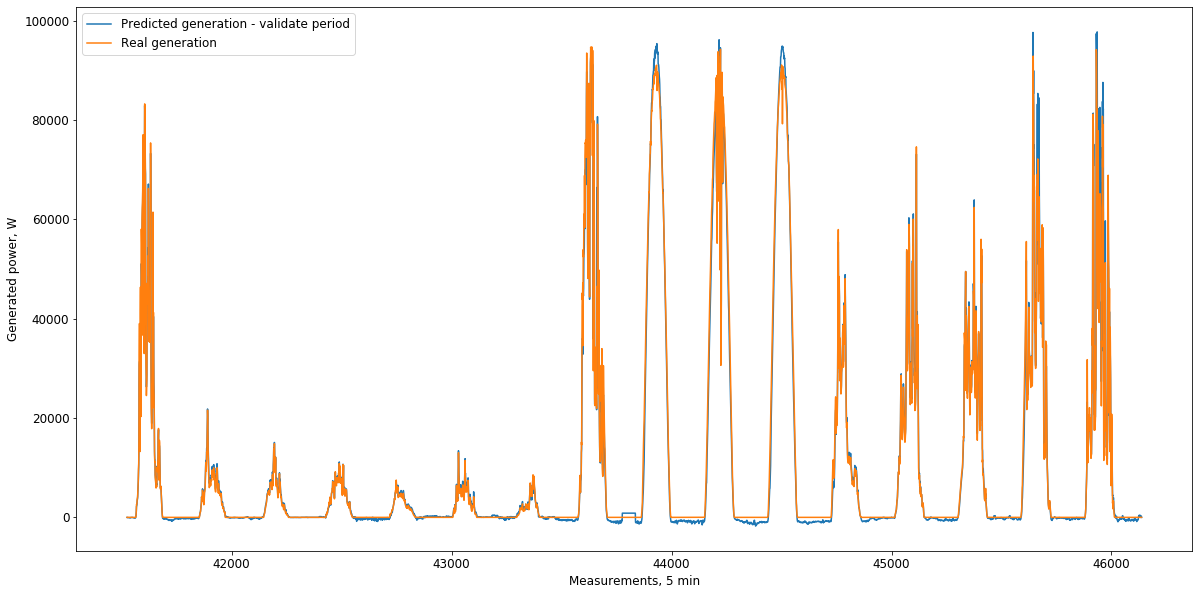

In [54]:
PV_predicted_validate_quad = PV_model_quad.predict(PV_features_quad_validate) # predicted for the validate period
plot_power_graph(PV_y_validate, PV_predicted_validate_quad, "Predicted generation - validate period")

In [55]:
PV_features_quad.shape, PV_features_quad_train.shape

((46138, 7), (41524, 7))

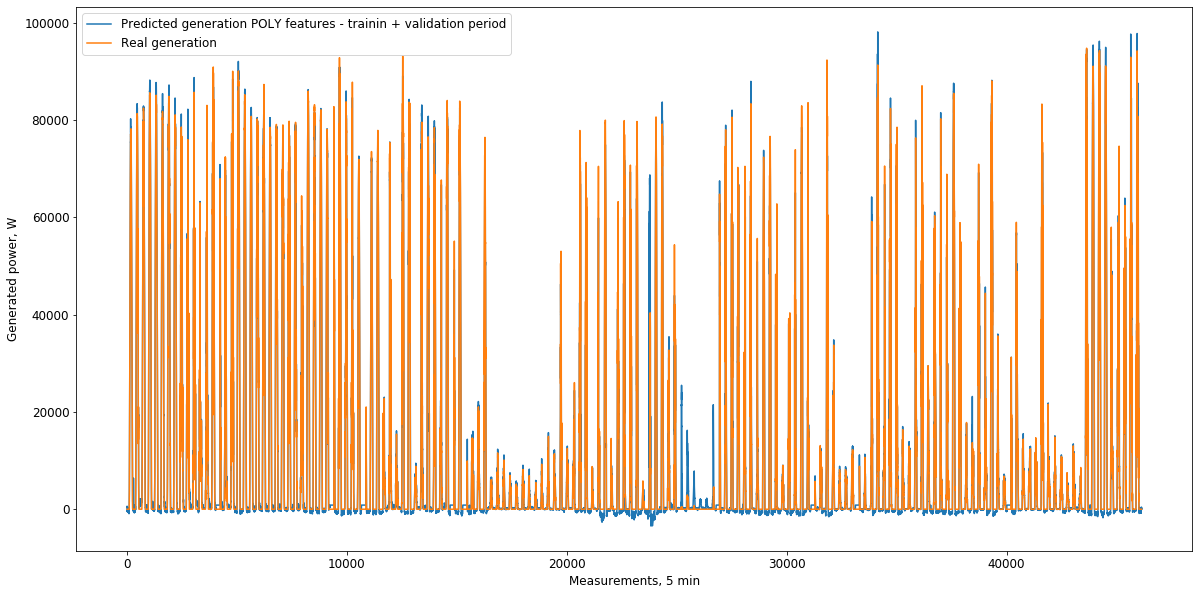

In [56]:
PV_predicted_quad_all = PV_model_quad.predict(PV_features_quad) # for the whole period training + validation period
plot_power_graph(PV_y, PV_predicted_quad_all, "Predicted generation POLY features - trainin + validation period")

In [57]:
#print((PV_predicted_quad).min())
#x= list(PV_predicted_quad)
#print(min(x))
#x.index(min(x))/288

In [58]:
RMSE_calc(PV_y , PV_predicted_quad_all, PV_y_validate, PV_predicted_validate_quad)

Rooted MSE whole period : 2.27 kW
Rooted MSE test period : 1.96 kW
Normalised Rooted MSE test period : 2.04 %


The polynomial features improved the baseline model result from 0.98479 to 0.99195, reduced the RMSE, and reduced the visible peaks in the graph, which on the other hand still exist. 

But actually we dont need the accuracy of the model during the night - the solar iradiance is zero and the models calculates easy zero. We do not need this prediction, but when calculate the RMSE with all measurements, including nights, this is reducing the error When we calculate the RMSE only for the periods during the days, the error is being reduced unnaturally. That is why, we must introduce new metrics, which is calculating the RMSE only during the days. 

When we used the function RMSE_calc_during_days it could be noticed that the RMSE is looking closer to the peak difference show in the graphs.

In [59]:
RMSE_calc_during_days(PV_y, PV_predicted_quad_all, PV_y_validate, PV_predicted_validate_quad)

Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %


In [60]:
RMSE_calc_during_days(PV_y , PV_predicted_all, PV_y_validate, PV_predicted_validate) # BASELINE MODEL

Rooted MSE whole period (only daylight): 4.54 kW
Rooted MSE test period (only daylight): 4.05 kW
Normalized Rooted MSE test period (only daylight): 4.21 %


The above are compare the RMSE during the days for the poly features and baseline model. The Poly features model reduces considerably the errors.

In [61]:
109888834534.9696/8240

13336023.608612817

In [62]:
np.sqrt(13336023.608612817)

3651.852079234976

In [63]:
PV_y_validate.index.min()

41524

In [64]:
PV_predicted_validate_quad[0]

-12.392095928184062

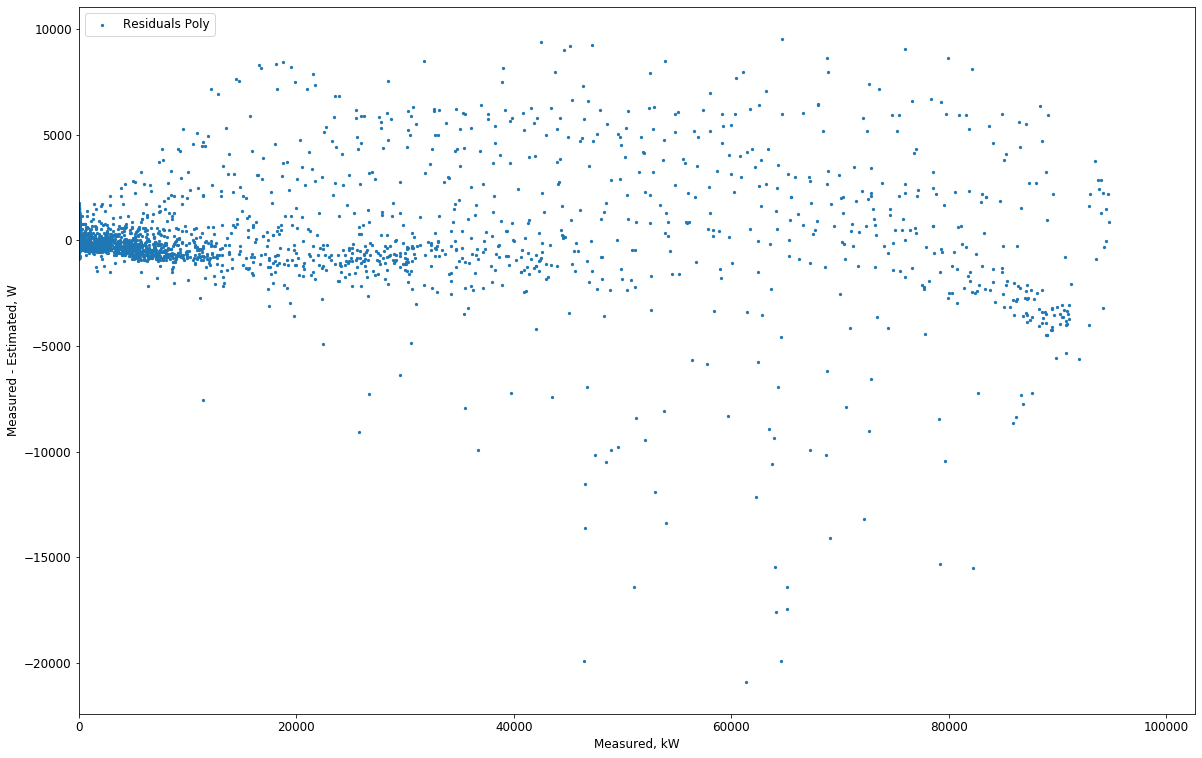

In [65]:
plot_residuals(PV_y_validate, PV_predicted_validate_quad, "Residuals Poly")

In [66]:
print((PV_y - PV_predicted_quad_all).min())
x= list((PV_y-PV_predicted_quad_all).abs())
print(max(x))
x.index(max(x))/288

-70825.63566683535
70825.63566683535


14.684027777777779

In [67]:
df.loc[(df['Power'] == 0) & 
              (df['Insolation'] > 5)]  

,Power,Wind speed,Module temperature,Ambient temperature,Insolation,DC power input[A],DC power input[B]
4229,0,2.14,49.6,28.1,852.0,33670.0,10233
4230,0,1.85,44.9,26.4,821.0,51526.0,15433
22851,0,2.58,-1.4,1.2,6.0,135.0,49
23513,0,0.85,-4.2,-3.0,9.0,351.0,153
23514,0,0.20,-4.2,-2.9,8.0,316.0,138
...,...,...,...,...,...,...,...
50498,0,0.00,-1.7,-0.6,12.0,143.0,40
50499,0,0.00,-1.6,-0.5,14.0,143.0,42
50500,0,0.00,-1.3,-0.4,15.0,144.0,48
50501,0,0.00,-1.1,-0.3,16.0,120.0,42


From the scatter plot could be noticed that most of the residuals are situated near the zero. There are some out lying residual values of minus 25-30 000 W, when the value of the measured is zero. This looks very strange in the beggining but one could easily guess that the case is that there is recorded independent variables like solar radiance and ambient temperature, and on the other hand - there is no recorded measured value for the generated power. This means that either at this specific moment the power plant is not working or it is not recording. We checked the indexes of these values, and guessed the day (every normal working day there are 288 recordings if there is sun or not). In this cases the first records start not at 12:00 at midnight, but at 13:00 midday, for example. The solar irradiance and ambient temperature start recording at 13:00, and the generated power start recording at 13:10, 2 measurement intervals later. It seems there was some fault in the power plant, which was repaired, and the PP we turned on at 13:00. The measurement of the power started 10 minutes later than other recordings and it seems it such cases and days we will have several mising values of generated power. There 2 columns DC power [A] and DC power [B] which are the sum of all PV moduls generated power in the entrance of the PV inverter. As the missing value is the power on the outer end of the inverter, if there is recorded values for the 2 DC entrances, this means there is power on the outer end, as well. It is just not recorded. In other words, we must decide what to do with these missing values. For now we will do nothing.

Another thing that could be noticed from the scatter plot is there are no distinguishable clusters of residuals - linearly situated accros the x axis, and in the big values of measured values, there is certain randomness in the residuals.  

The linear model  is showing good R2 coefficient and relativelly low RMSE. This is calculated as average for a relatively long periods. But if our model is being practically used for a prediction (what will be the generation of the PP in the next days), and this numbers are transfered to the electric power utilities, must be sure that the pear values of the errors are as reduced as possible.

We must check if Polynomial features will explain better the connection between the dependent and independent variables.

In [68]:
list_of_indexes = df.loc[(df['Power'] == 0) & 
              (df['Insolation'] > 5)].index  
len(list_of_indexes)

280

In [69]:
#for idx in list_of_indexes:
#  if idx < len(PV_y):#print(PV_y[idx])
#    PV_y[idx] = PV_predicted_quad_all[idx]

In [70]:
#PV_features_quad_train, PV_features_quad_validate, PV_y_train, PV_y_validate = train_test_split(PV_features_quad, PV_y, test_size=0.10, shuffle = False)

In [71]:
#PV_model_quad = LinearRegression()
#PV_model_quad.fit(PV_features_quad_train, PV_y_train)
#model_score_quad = PV_model_quad.score(PV_features_quad_validate, PV_y_validate)
#model_score_quad_train = PV_model_quad.score(PV_features_quad_train, PV_y_train)

#print("Model Quad Score: {:.5f}".format(model_score_quad))
#print("Model Quad Score on the train set: {:.5f}".format(model_score_quad_train))

In [72]:
#PV_predicted_validate_quad = PV_model_quad.predict(PV_features_quad_validate) # predicted for the validate period
#PV_predicted_quad_all = PV_model_quad.predict(PV_features_quad) # predicted for the test period
#RMSE_calc_during_days(PV_y, PV_predicted_quad_all, PV_y_validate, PV_predicted_validate_quad)

In [73]:
#RMSE_calc(PV_y, PV_predicted_quad_all, PV_y_validate, PV_predicted_validate_quad)

In [74]:
#PV_predicted_quad = PV_model_quad.predict(PV_features_quad) # for the whole period training + validation period
#plot_power_graph(PV_y, PV_predicted_quad, "Predicted generation POLY features after missing values - trainin + validation period")

In [75]:
#PV_predicted_quad.min(), PV_model_quad.intercept_,PV_y.min(),PV_predicted_quad[-10971.686761383158].index

In [76]:
PV_features_quad_15_days = PV_features_quad[len(PV_features_quad)-30*288:len(PV_features_quad)-15*288]
PV_y_15_days = PV_y[len(PV_features_quad)-30*288:len(PV_features_quad)-15*288]

PV_features_quad_15_days = PV_features_quad[15*288:30*288]
PV_y_15_days = PV_y[15*288:30*288]


PV_features_quad_15_days.shape, PV_y_15_days.shape
PV_features_quad_train_15, PV_features_quad_validate_15, PV_y_train_15, PV_y_validate_15 = train_test_split(PV_features_quad_15_days, PV_y_15_days, test_size=0.20, shuffle = False)

In [77]:
PV_model_quad_15 = LinearRegression()
PV_model_quad_15.fit(PV_features_quad_train_15, PV_y_train_15)
model_score_quad_15 = PV_model_quad_15.score(PV_features_quad_validate_15, PV_y_validate_15)
model_score_quad_train_15 = PV_model_quad_15.score(PV_features_quad_train_15, PV_y_train_15)

print("Model Quad Score: {:.5f}".format(model_score_quad_15))
print("Model Quad Score on the train set: {:.5f}".format(model_score_quad_train_15))

Model Quad Score: 0.99682
Model Quad Score on the train set: 0.99867


In [78]:
PV_predicted_validate_quad_15 = PV_model_quad_15.predict(PV_features_quad_validate_15) # predicted for the validate period
PV_predicted_quad_all_15 = PV_model_quad.predict(PV_features_quad_15_days) # predicted for the test period
RMSE_calc(PV_y_15_days, PV_predicted_quad_all_15, PV_y_validate_15, PV_predicted_validate_quad_15)

Rooted MSE whole period : 1.48 kW
Rooted MSE test period : 1.57 kW
Normalised Rooted MSE test period : 1.63 %


The LR model, trained till now, is trained on the whole training set, and calculates optimal coefficients of the model  parameters for the whole period. If the seasonality of the sun insolation, or rainy or cloudy periods, affect the coefficients, or in other words there are optimal coefficients for winter and summer periods, it is a worthy experiment to check whether shorter training sets could prove better in terms of prediction and RMSE. In other words, if such model is put into practice, and today we must predict the next 3 or 5 days, is it worhty to use the trained coefficients of past 300 days for training set, or just exactly the last 10-12 days. The above presented experiment could be implemented in a "for" cycle. For the first period of higher model prediction (from the graph), the experiment shows much lower errors. For the last period, the error is not lower compared with the "whole" model. This could be checked if it is a better approach, the mean value of the RMSE mush be lower for the whole period.

In [79]:
#PV_features_quad_validate.shape
#print(6216/288)
#PV_features_quad_validate_faulted_period = PV_features_quad_validate[10*288:]
#PV_y_validate_faulted_period = PV_y_validate[10*288:]
#PV_features_quad_validate_faulted_period.shape, PV_y_validate_faulted_period.shape

In [80]:
#PV_predicted_validate_quad_faulted_period = PV_model_quad.predict(PV_features_quad_validate_faulted_period) # predicted for the faulted period

In [81]:
#model_score_quad_faulted_period = PV_model_quad.score(PV_features_quad_validate_faulted_period, PV_y_validate_faulted_period)

#print("Model Quad Score on the faulted period: {:.5f}".format(model_score_quad_faulted_period))

Again, 9 days from the supposedly faulted period are plotted, in order to see better, that some of the days are predicted quite well, and some of the days, the prediction is higher than measured. This should be blamed on cloudy days, not on a supposed fault.

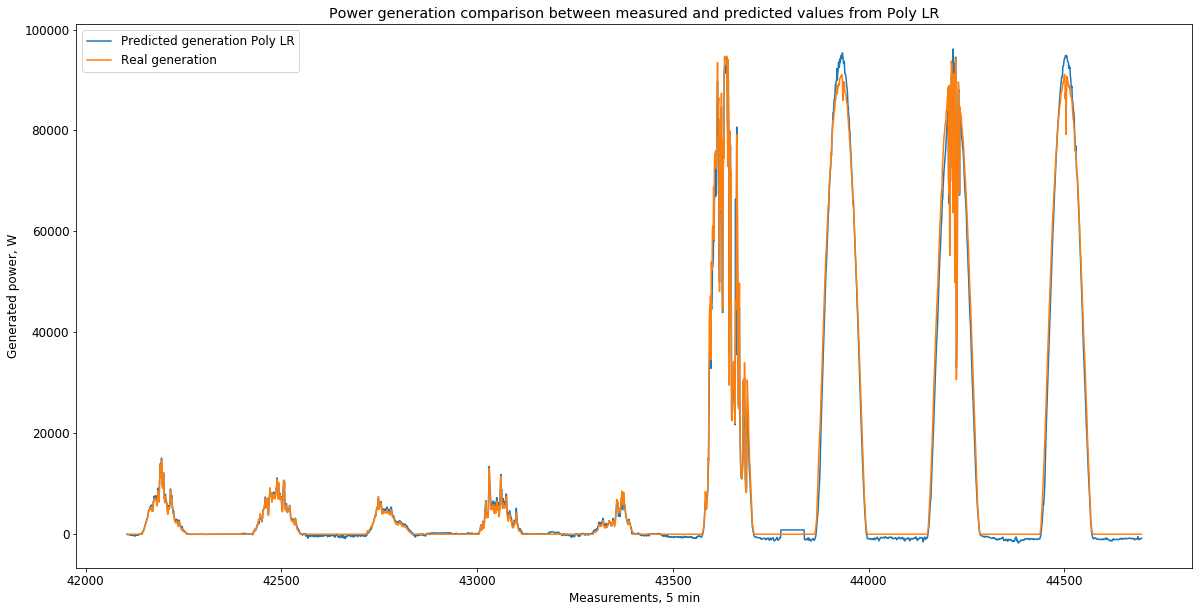

In [82]:
plot_days(PV_y, PV_predicted_quad_all, "Poly LR", 9, len(PV_y) - 5 * 288)

In [83]:
#PV_y_validate.index, PV_predicted_quad_all.shape

In [84]:
#model_EN = ElasticNetCV()
#model_EN.fit(PV_features_quad_train, PV_y_train)
#model_EN.score(PV_features_quad_validate, PV_y_validate)

In [85]:
#model_Ridge = Ridge(alpha=100)
#model_Ridge.fit(PV_features_quad_train, PV_y_train)
#model_Ridge.score(PV_features_quad_validate, PV_y_validate)

In [86]:
#PV_predicted_quad_all_Ridge = model_Ridge.predict(PV_features_quad) # predicted for the test period
#PV_predicted_quad_Ridge = model_Ridge.predict(PV_features_quad_validate) # predicted for the test period

In [87]:
#RMSE_calc_during_days(PV_y, PV_predicted_quad_all_Ridge, PV_y_validate, PV_predicted_quad_Ridge)

In [88]:
#RMSE_calc(PV_y, PV_predicted_quad_all_Ridge, PV_y_validate, PV_predicted_quad_Ridge)

In [89]:
#model_Lasso = Lasso()
#model_Lasso.fit(PV_features_quad_train, PV_y_train)
#model_Lasso.score(PV_features_quad_validate, PV_y_validate)

In [90]:
#model_Lasso.coef_

In [91]:
#PV_predicted_quad_all_Lasso = model_Lasso.predict(PV_features_quad) # predicted for the test period
#PV_predicted_quad_Lasso = model_Lasso.predict(PV_features_quad_validate) # predicted for the test period

In [92]:
#RMSE_calc_during_days(PV_y, PV_predicted_quad_all_Lasso, PV_y_validate, PV_predicted_quad_Lasso)

In [93]:
#RMSE_calc(PV_y, PV_predicted_quad_all_Lasso, PV_y_validate, PV_predicted_quad_Lasso)

In [94]:
model_DT = DecisionTreeRegressor()
model_DT.fit(PV_features_quad_train, PV_y_train)
model_DT.score(PV_features_quad_validate, PV_y_validate)

0.987463654286459

In [95]:
PV_predicted_quad_all_DT = model_DT.predict(PV_features_quad) # predicted for the test period
PV_predicted_quad_DT = model_DT.predict(PV_features_quad_validate) # predicted for the test period

In [96]:
RMSE_calc_during_days(PV_y, PV_predicted_quad_all_DT, PV_y_validate, PV_predicted_quad_DT)

Rooted MSE whole period (only daylight): 1.25 kW
Rooted MSE test period (only daylight): 3.70 kW
Normalized Rooted MSE test period (only daylight): 3.85 %


In [97]:
RMSE_calc(PV_y, PV_predicted_quad_all_DT, PV_y_validate, PV_predicted_quad_DT)

Rooted MSE whole period : 0.77 kW
Rooted MSE test period : 2.45 kW
Normalised Rooted MSE test period : 2.55 %


Support Vector Machines, the regression aplication Support Vector Regressor are considered universal approximator. For this reason we will include them in our research for optimal model and estimator.
The hyperparameters are very important for the SRV, and due to the considerably slow computation the gridsearch and hyper parameter tuning will be done specifically for this method. 

The results, with the proposed parameters from the gridsearch is SVR(C=1000, epsilon=0.01, gamma=0.5), kernel = rbf, cv =2, with best R2 score of the best grid estimator = 0.98554, RMSE whole period (only daylight): 3.45 kW, RMSE validate period (only daylight): 3.92 kW, nRooted MSE validate period (only daylight): 4.09 %. 

Thie results are not higher than the results of the LR with poly features, and due to the much more longer computation time will not be included in the research from now on.

In [98]:
#parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.9],'C': [1, 10, 100, 1000,]}]
#print("Tuning hyper-parameters")
#svr = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = 2)
#svr.fit(PV_features_quad_train, PV_y_train)

GridSearchCV(cv=2, estimator=SVR(epsilon=0.01),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                          'kernel': ['rbf']}])

In [99]:
#svr.best_estimator_

svr.best_estimator_   -> SVR(C=1000, epsilon=0.01, gamma=0.5)

In [100]:
#svr.best_estimator_.score(PV_features_quad_validate, PV_y_validate) #0.9855446106245065

In [101]:
#PV_predicted_quad_all_SVR = svr.best_estimator_.predict(PV_features_quad) # predicted for the test period
#PV_predicted_quad_SVR = svr.best_estimator_.predict(PV_features_quad_validate) # predicted for the test period

In [102]:
#RMSE_calc_during_days(PV_y, PV_predicted_quad_all_SVR, PV_y_validate, PV_predicted_quad_SVR)

In [103]:
#plt_period_begginig = len(PV_y_validate) - 9*288

In [104]:
#plot_days(PV_y_validate, PV_predicted_quad_DT, "DT", 9)

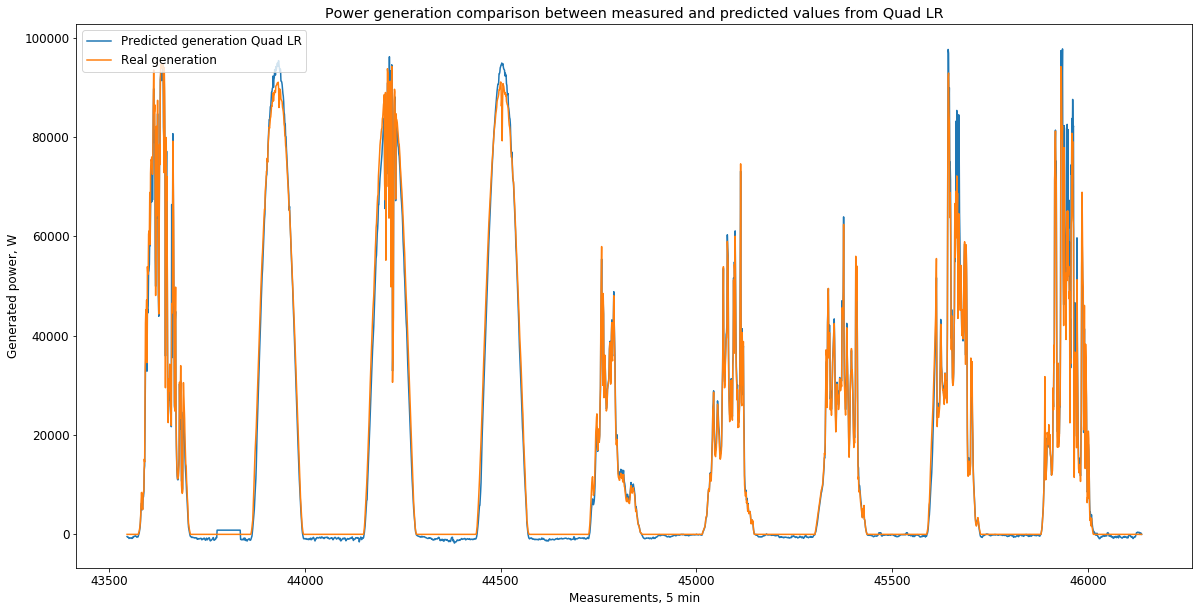

In [105]:
plot_days(PV_y_validate, PV_predicted_validate_quad, "Quad LR", 9)

In [106]:
PV_model_quad.coef_

array([ 58737.20490246,  13379.39088017,  48422.41923963, -79018.60984739,
         1431.52007103, -23098.78291785, -48466.25479736])

In [107]:
model_DT.feature_importances_

array([0.7185646 , 0.00310077, 0.14274759, 0.12143116, 0.00496334,
       0.00141845, 0.00777408])

In [108]:
model_DT.n_features_

7

Below is proposed example of alghoritm which calculates a given set of methods with their default set of parameters. There is no specific need of Lasso regularization or Ridge, as there is no serious overfitting of the main model till the moment - LR with polynomial features. 

The proposed for cycle, which easily could be implemented in a function, if needed, is showing the results of the included proposed methods, and they are not better than the result of LR with poly features. 

Later, we intent to check, if the LR model, again proves as optimal, whether a poly LR, but this time with fewer features - Ambient temperature and Solar Radiation will have similar results. The idea is that this two parameters is easier to obtain from climatic forecast for practical use of such model, compared to the "Module temperature" and "Wind" features.

In [109]:
regression_algorithms = [('LinerRegression', LinearRegression()), ('Lasso',  LassoCV()), ('Ridge', RidgeCV()),
 ('DT',  DecisionTreeRegressor()),  ('RandomF',  RandomForestRegressor())] #('ElasticNetCV',  ElasticNetCV()),

In [110]:
for estimator in (regression_algorithms):

    pipe = Pipeline([estimator] )   
    pipe.fit(PV_features_quad_train, PV_y_train)
    
    print(f"\nthe score on test set of {[estimator[0]]} is : {pipe.score(PV_features_quad_validate, PV_y_validate):.5f}")

    PV_predicted_quad_all = pipe.predict(PV_features_quad) # predicted for the whole period
    PV_predicted_quad = pipe.predict(PV_features_quad_validate) # predicted for the test period
    
    RMSE_calc_during_days(PV_y , PV_predicted_quad_all, PV_y_validate, PV_predicted_quad)
    



the score on test set of ['LinerRegression'] is : 0.99195
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %

the score on test set of ['Lasso'] is : 0.99170
Rooted MSE whole period (only daylight): 3.53 kW
Rooted MSE test period (only daylight): 2.97 kW
Normalized Rooted MSE test period (only daylight): 3.10 %

the score on test set of ['Ridge'] is : 0.99195
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.04 %

the score on test set of ['DT'] is : 0.98736
Rooted MSE whole period (only daylight): 1.25 kW
Rooted MSE test period (only daylight): 3.71 kW
Normalized Rooted MSE test period (only daylight): 3.87 %

the score on test set of ['RandomF'] is : 0.99137
Rooted MSE whole period (only daylight): 1.39 kW
Rooted MSE test period (only daylight): 3.08 kW
Normalized Rooted MSE test pe

In [111]:
#model_RF = RandomForestRegressor()
#model_RF.fit(PV_features_quad_train, PV_y_train)
#model_RF.score(PV_features_quad_validate, PV_y_validate)

In [112]:
#PV_predicted_quad_all_RF = model_RF.predict(PV_features_quad) # predicted for the test period
#PV_predicted_quad_RF = model_RF.predict(PV_features_quad_validate) # predicted for the test period

In [113]:
#RMSE_calc(PV_y, PV_predicted_quad_all_RF, PV_y_validate, PV_predicted_quad_RF) 

### 5.4 GridSearch 

A pipeline for the cycle grid search is proposed below, for several alghoritms. For now, it has the downside of not storing the parameters of each best estimator, the cv results, etc in specific variable. This could be solved by introducin a dictionary, if needed.

In [114]:
regression_algorithms = [('LinerRegression', LinearRegression()), ('Lasso',  Lasso()), ('Ridge', Ridge()),
                         ('DT',  DecisionTreeRegressor()), ('RandomF',  RandomForestRegressor())]
regression_algorithms[3]

('DT', DecisionTreeRegressor())

In [115]:
for estimator in (regression_algorithms):
    print(estimator)

('LinerRegression', LinearRegression())
('Lasso', Lasso())
('Ridge', Ridge())
('DT', DecisionTreeRegressor())
('RandomF', RandomForestRegressor())


In [116]:
# LR, Lasso, Ridge,DecisionTreeRegressor
depth = np.arange(30,80)

parameters = [{ "fit_intercept": [True, False]
              }, 
                { "alpha": [0.005, 0.02, 0.05, 0.06, 0.09, 0.1], "fit_intercept": [True, False]
                },
                {  "alpha": [0.005, 0.02, 0.05, 0.09, 1, 10, 100, 500], "fit_intercept": [True, False],
                    "solver":['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
                },
                {"max_depth": [5, 10, 20 , 30, 34, 40, 48, 50, 56,  60,  70], 
                 "min_samples_leaf": [1, 2, 5, 10, 20, 25, 30] 
                },
              {'n_estimators': [100, 200,300], 'max_features': [5, 10], 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
                             
                ]
parameters[4]

{'n_estimators': [100, 200, 300],
 'max_features': [5, 10],
 'max_depth': [10, 50, None],
 'bootstrap': [True, False]}

In [117]:
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [118]:
counter = 0
for estimator in (regression_algorithms):

    grid_search = GridSearchCV(estimator[1], param_grid = parameters[counter], n_jobs=-1, cv=2,scoring=mse)
    grid_search.fit(PV_features_quad_train, PV_y_train)
    
    print(f'\n{grid_search.best_estimator_}')
    #tuned_score = grid_search.best_estimator_.predict(PV_features_quad_test)
    tuned_score = grid_search.best_estimator_.score(PV_features_quad_validate, PV_y_validate)
    print(f"{tuned_score:.6f}")
    counter +=1
    
    PV_predicted_quad_all = grid_search.best_estimator_.predict(PV_features_quad) # predicted for the whole period
    PV_predicted_quad = grid_search.best_estimator_.predict(PV_features_quad_validate) # predicted for the test period
    
    RMSE_calc_during_days(PV_y, PV_predicted_quad_all, PV_y_validate, PV_predicted_quad)

    


LinearRegression()
0.991953
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %

Lasso(alpha=0.005)
0.991953
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %

Ridge(alpha=0.005, solver='sparse_cg')
0.991839
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.93 kW
Normalized Rooted MSE test period (only daylight): 3.06 %

DecisionTreeRegressor(max_depth=48)
0.987432
Rooted MSE whole period (only daylight): 1.25 kW
Rooted MSE test period (only daylight): 3.70 kW
Normalized Rooted MSE test period (only daylight): 3.86 %

RandomForestRegressor(bootstrap=False, max_depth=50, max_features=5,
                      n_estimators=300)
0.991297
Rooted MSE whole period (only daylight): 1.04 kW
Rooted MSE test period (only daylight): 3.09 kW
Normalized 

LinearRegression()
0.991953
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %

Lasso(alpha=0.005)
0.991953
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.91 kW
Normalized Rooted MSE test period (only daylight): 3.03 %

Ridge(alpha=0.005, solver='sparse_cg')
0.991839
Rooted MSE whole period (only daylight): 3.48 kW
Rooted MSE test period (only daylight): 2.93 kW
Normalized Rooted MSE test period (only daylight): 3.06 %

DecisionTreeRegressor(max_depth=70)
0.987096
Rooted MSE whole period (only daylight): 1.27 kW
Rooted MSE test period (only daylight): 3.75 kW
Normalized Rooted MSE test period (only daylight): 3.91 %

RandomForestRegressor(bootstrap=False, max_depth=50, max_features=5)
0.991312
Rooted MSE whole period (only daylight): 1.04 kW
Rooted MSE test period (only daylight): 3.09 kW
Normalized Rooted MSE test period (only daylight): 3.22 %

In [119]:
#grid_search.cv_results_

For the optimal model from the validate set research is chosen the LR model with polynomial features, as it presents optimal levels of error, and computation time. Which in case a retraining in a practical usage is needed, will be beneficial. Due to this, for the final check on the test set will be used LR with polynomial features.

In [120]:
#np.logspace(-5, 2, 100)

## 6. FINAL TEST CHECK 

In [121]:
PV_features_test.shape, PV_y_test.shape

((5126, 4), (9228,))

In [122]:
#PV_features_2 = df[['Ambient temperature', 'Insolation','Wind speed', "Module temperature" ]] #
#PV_features_2.shape

In [123]:
#PV_y_unshaped = df.Power
#PV_y_unshaped.shape

In [124]:
sc_2 = MinMaxScaler()
scaled_X_2 = sc_2.fit_transform(PV_features_test)
scaled_X_2.shape
print(len(scaled_X_2), len(PV_y_test))

5126 9228


In [125]:
quad_feature_transformer = PolynomialFeatures(degree = 2, interaction_only = False)
PV_features_quad_final_test = quad_feature_transformer.fit_transform(scaled_X_2)

In [126]:
pca_2 = PCA()
X_pca_2 = pca_2.fit_transform(PV_features_quad_final_test)
print(X_pca_2.shape)
print(pca_2.explained_variance_ratio_)
print(np.cumsum(pca_2.explained_variance_ratio_))
#X_pca_2 = X_pca_2[:,:3]
X_pca_2.shape

(5126, 15)
[6.42097420e-01 2.01724362e-01 1.20206902e-01 1.39357847e-02
 7.48811791e-03 5.50821659e-03 4.21922886e-03 2.12919439e-03
 1.29977366e-03 9.96901634e-04 3.04079030e-04 5.30617520e-05
 3.20171733e-05 4.94012736e-06 0.00000000e+00]
[0.64209742 0.84382178 0.96402868 0.97796447 0.98545259 0.9909608
 0.99518003 0.99730923 0.998609   0.9996059  0.99990998 0.99996304
 0.99999506 1.         1.        ]


(5126, 15)

In [127]:
X_pca_2 = X_pca_2[:,:7]
X_pca_2.shape

(5126, 7)

In [128]:
PV_features_quad_final_test = X_pca_2

In [129]:
PV_features_quad_final_test.shape, PV_y_test.shape

((5126, 7), (9228,))

In [130]:
PV_y_test = PV_y_unshaped[end_of_validation_set:]

In [131]:
model_score_quad_test = PV_model_quad.score(PV_features_quad_final_test, PV_y_test)
print("Model Quad Score on the TEST set: {:.5f}".format(model_score_quad_test))

Model Quad Score on the TEST set: 0.87202


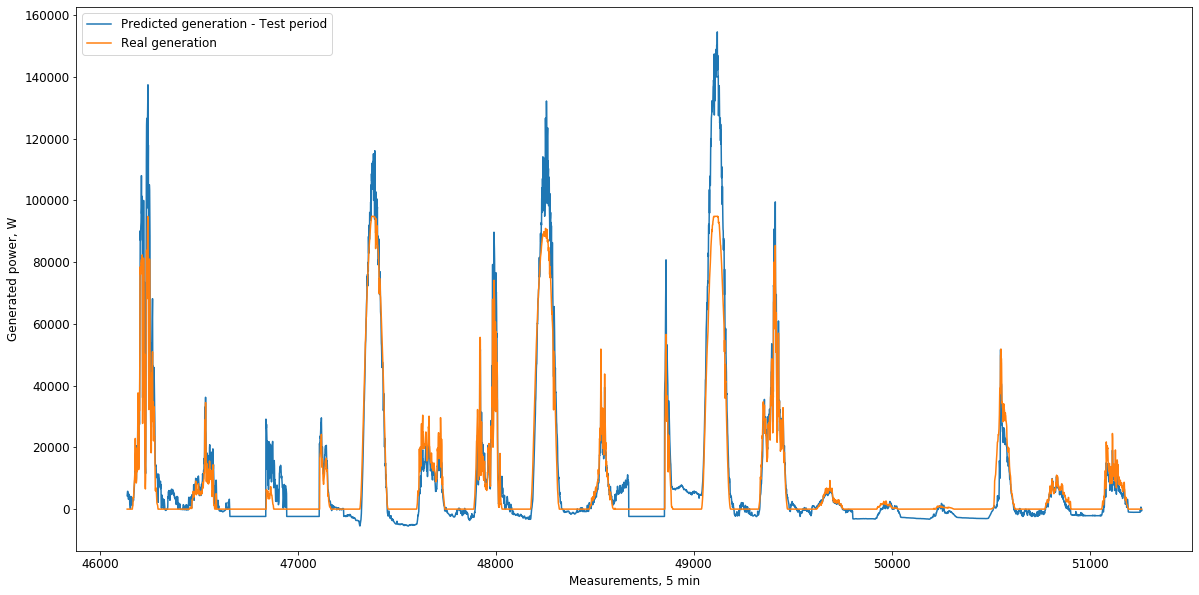

In [132]:
PV_predicted_quad_final_test = PV_model_quad.predict(PV_features_quad_final_test) # predicted for the validate period
plot_power_graph(PV_y_test, PV_predicted_quad_final_test, "Predicted generation - Test period")

This is considerably lower result than expected. We must find the reason. First, we can check what will be the result of baseline model, on the whole data set from the beggining, without validation set. Only train and test. 

This is high result, althogh not perfect and lower, than the previous result, and finding the reason is important. The results of the experiment from above with only 15 days training + test set, were much higher. The reason why the coefficients of the train + test describe much better the data compared with train + validation + test set should be due to seasonality. 

In other words - data drift. The available data starts from September and ends in March. It seems that the measured data for temperature and solar radiation change from autumn, through the winter and again in the beggining of the spring in enough degrees, so the a model that describes almost perfectly the data in validation set, on the test set, is not so good. This means the optimal coefficient have changed, and it should be a good idea to retrain the model with more recent data for optimal coefficients. 

In [133]:
PV_model_quad.coef_

array([ 58737.20490246,  13379.39088017,  48422.41923963, -79018.60984739,
         1431.52007103, -23098.78291785, -48466.25479736])

We could make experiment for a case where we take the last 60 days of the available data, all of the situated in the lower result of the final test data.

In [134]:
PV_features_quad_15_days = PV_features_unshaped[len(PV_features_unshaped)-60*288:len(PV_features_unshaped)-0*288]
PV_y_15_days = PV_y_unshaped[len(PV_features_unshaped)-60*288:len(PV_features_unshaped)-0*288]

#PV_features_quad_15_days = PV_features_quad[15*288:30*288]
#PV_y_15_days = PV_y[15*288:30*288]

quad_feature_transformer = PolynomialFeatures(degree = 2, interaction_only = False)
PV_features_quad_15 = quad_feature_transformer.fit_transform(PV_features_quad_15_days)

PV_features_quad_15.shape
PV_features_quad_15 = PV_features_quad_15 [:,:7]
PV_features_quad_15.shape

(17280, 7)

In [135]:
PV_features_quad_15_days.shape, PV_y_15_days.shape
PV_features_quad_train_15, PV_features_quad_test_15, PV_y_train_15, PV_y_test_15 = train_test_split(PV_features_quad_15, PV_y_15_days, test_size=0.20, shuffle = False)

In [136]:
PV_model_quad_15 = LinearRegression()
PV_model_quad_15.fit(PV_features_quad_train_15, PV_y_train_15)
model_score_quad_15 = PV_model_quad_15.score(PV_features_quad_test_15, PV_y_test_15)
model_score_quad_train_15 = PV_model_quad_15.score(PV_features_quad_train_15, PV_y_train_15)

print("Model Quad Score: {:.5f}".format(model_score_quad_15))
print("Model Quad Score on the train set: {:.5f}".format(model_score_quad_train_15))

Model Quad Score: 0.98699
Model Quad Score on the train set: 0.99262


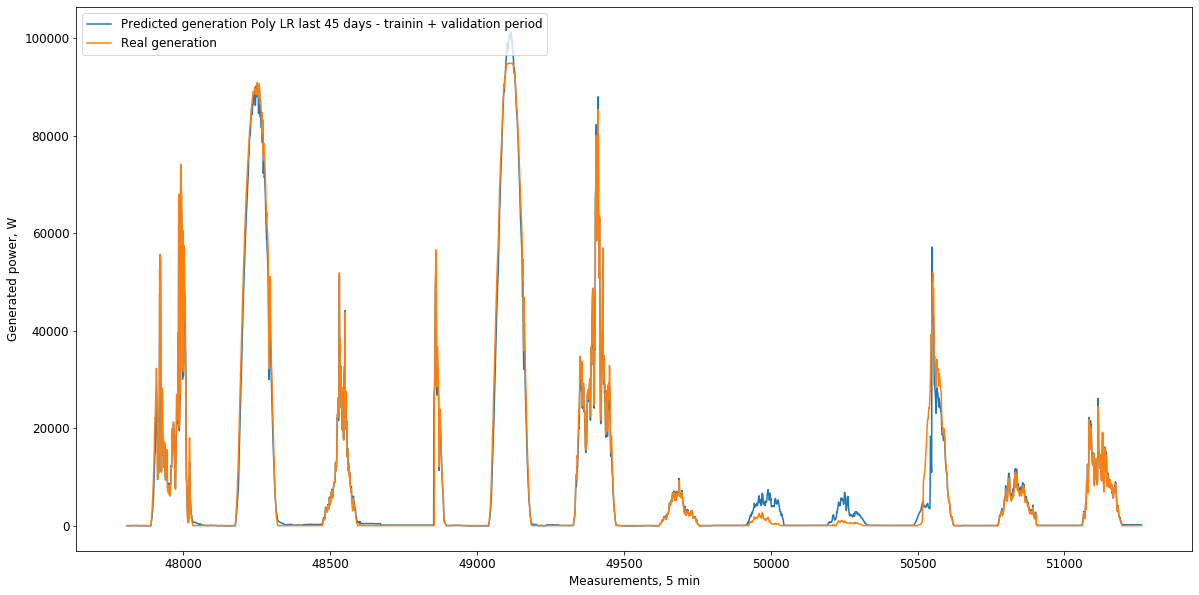

In [137]:
PV_test_quad_15 = PV_model_quad_15.predict(PV_features_quad_test_15) # predicted for the test period
plot_power_graph(PV_y_test_15, PV_test_quad_15, "Predicted generation Poly LR last 45 days - trainin + validation period")

In [138]:
PV_predicted_quad_15_whole = PV_model_quad_15.predict(PV_features_quad_15) # predicted for the test period
RMSE_calc(PV_y_15_days, PV_predicted_quad_15_whole, PV_y_test_15, PV_test_quad_15)

Rooted MSE whole period : 1.76 kW
Rooted MSE test period : 2.27 kW
Normalised Rooted MSE test period : 2.37 %


In [139]:
#PV_y_15_days.shape, PV_features_quad_15.shape, PV_predicted_quad_15.shape, PV_y_validate_15.shape

In [140]:
sc = MinMaxScaler()
pca = PCA(n_components = 3)
poly_features = PolynomialFeatures(degree = 2, interaction_only = False)
pca_2 = PCA(n_components = 6)
lin_reg = LinearRegression()

pv_reg = Pipeline([
                    ('MinMaxScalar', sc),
                    ('PCA', pca),
                    ('Poly_features', poly_features),
                    ('PCA_2', pca_2),
                    ('Linear Regression', lin_reg)
    
                 ])

#PV_features_quad_final_test
#PV_features_test , PV_y_test
#PV_features_train, PV_y_train,

poly_reg_model = pv_reg.fit(PV_features_train , PV_y_train)
poly_reg_model = pv_reg.predict(PV_features_test)
score_pipe = pv_reg.score(PV_features_test , PV_y_test)
score_pipe

0.9759781746238396

## 7. Conclusions and discussion

What we saw from the above experiment is that in this case the results are much higher than from the model trained not the the last 50, but for the last 150 days. This could be also noticed from the graphs, where the periods overlap and we can compare the same day. In the second experiment - the prediction is hardly distinguishable from the measured values. Also, there are no negative predicted values, which are most like product of the fact that in the longer trained model the temperature during the training period is seasonably different than the temperature duting the test period.

This is a very good proof in the direction that for a practical usage of machine learning model for energy production of PV power plants will bring less errors of a shorter training period are used, instead of whole year, for example. This will lead to cycle retraining of the model.

Additional research could be implemented for the whole available data, in order to prove that periodical retraining of the model will deliver better mean results compared with the single time trained model.

In this paper, we researched the possibility to overcome the seasonality obstacle in modeling a whole year PV PP power generation, by modeling the autumn and winter months of the year,instead training the model on a whole year data, for a PP geographically situated in North West Bulgaria.

The proposed 4 base feature Linear Regression model with polynomian features on 2nd degree showed very good results on the validation set and lower, but acceptable results on the final test set.
An experiment was perfermed for a model, using only the last 60 days of the data set, practically retraining the same Poly LR model, which lead to very low error.

## References

[1] Machine Learning Algorithms for Photovoltaic System Power Output Prediction - Spyros Theocharides, George Makrides and George E.Georghiou, Department of Electrical and Computer Engineering, University of Cyprus, Andreas Kyprianou, Department of Mechanical and Manufacturing Engineering, University of Cyprus

[2] Solar Power Forecasting with Machine Learning Techniques - EMIL ISAKSSON, MIKAEL KARPE CONDE, DEGREE PROJECT IN MATHEMATICS,SECOND CYCLE, STOCKHOLM, SWEDEN 2018

[3] https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

[4] https://stackoverflow.com/questions/47414819/gridsearchcv-for-polynomial-regression?rq=1

[5] https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

[6] Solar Power Forecasting with Machine Learning Techniques - EMIL ISAKSSON, MIKAEL KARPE CONDE, DEGREE PROJECT IN MATHEMATICS,SECOND CYCLE, STOCKHOLM, SWEDEN 2018

[7] SHADOW EFFECTS ON A SERIES-PARALLEL ARRAY OF SOLAR CELLS, Ralph M. Sullivan, GODDARD SPACE FLIGHT CENTER

[8] https://en.wikipedia.org/wiki/Photovoltaic_effect],[https://en.wikipedia.org/wiki/Theory_of_solar_cells

[9]